In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [2]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [3]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [4]:
def load_data():
    data = pd.read_csv('/Users/namhunkim/Library/CloudStorage/OneDrive-연세대학교(YonseiUniversity)/DSL/정규세션/0804_supervised_learning/data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [5]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [6]:
# 결측값 및 자료형태 확인

train_x.info() # NaN없이 제대로 모든 값이 float형태로 들어있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temp           88 non-null     float64
 1   Wind           88 non-null     float64
 2   Moisture       88 non-null     float64
 3   Precipitation  88 non-null     float64
 4   Sun            88 non-null     float64
dtypes: float64(5)
memory usage: 3.6 KB


In [7]:
# 데이터 형태 확인

train_x.head(3)

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0


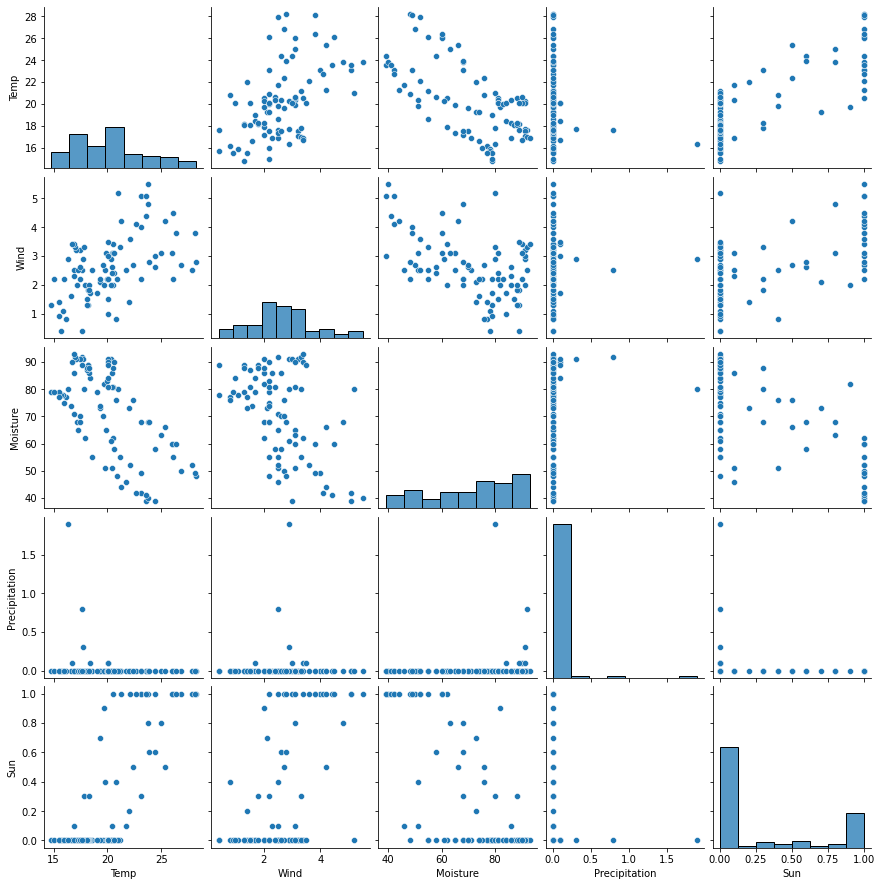

In [8]:
# 산점도 행렬 확인

sns.pairplot(train_x, diag_kind='hist');

In [9]:
# Precipitation은 0의 값이 매우 많은 분포를 가짐으로 예측값인 전력사용량을 위한 피처로 올바르지 않다.
# 따라서 Precipitation을 제외한 데이터로 하여금 산점도행렬을 다시 확인해보자.

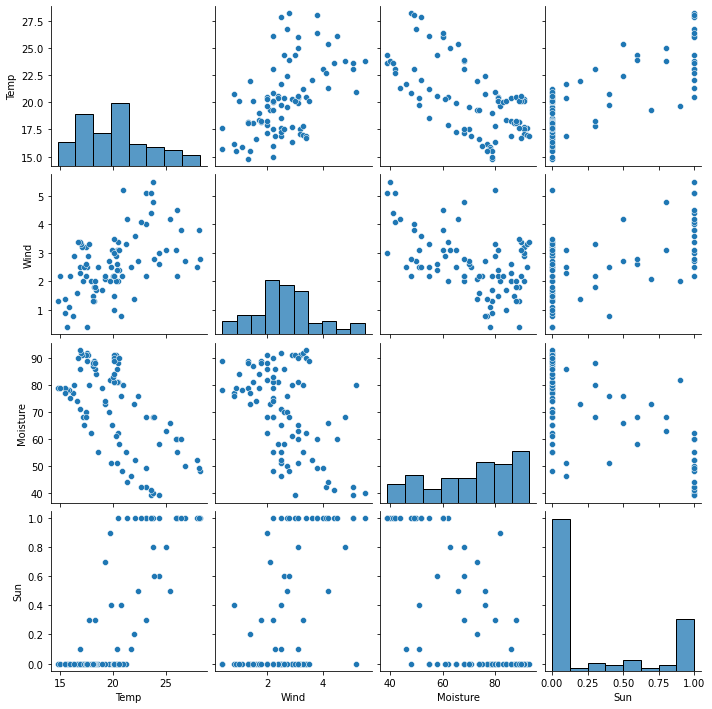

In [10]:
# Precipitation을 제외한 산점도 행렬 확인

train_x = train_x.drop(['Precipitation'],axis=1)
sns.pairplot(train_x, diag_kind='hist');

In [11]:
# 모든 값들이 서로 선형의 관계가 있는 것으로 보인다. 그러나 그렇다고 남은 4개의 피처를 1개만으로
# 표기하는데에 어려움이 있음으로, 상관계수를 직접적으로 구해 수치적으로 확인해보자.

# 상관행렬 확인

train_x.corr()

# 서로 상관관계가 높은 것들은 다음과 같다.
# (Temp,Sun)=0.78, (Moisture,Sun)=-0.70, (Temp,Moisture)=-0.63
# 가장 상관관계가 높은 Temp,Sun의 경우에는 잘 보면, Temp가 20을 넘기면 Sun이 1이고
# 반대로 Temp가 20이하이면 Sun은 0으로 나눠질 수 있을 것 같다.

,Temp,Wind,Moisture,Sun
Temp,1.000000,0.510935,-0.628642,0.783829
Wind,0.510935,1.000000,-0.478825,0.544720
Moisture,-0.628642,-0.478825,1.000000,-0.699047
Sun,0.783829,0.544720,-0.699047,1.000000


In [12]:
# Sun이 0일 때, 가장 큰 Temp값
print(max(train_x.Temp[np.where(train_x.Sun==0)[0]]))

# Sun이 1일 때, 가장 작은 Temp값
print(min(train_x.Temp[np.where(train_x.Sun==1)[0]]))

21.2
20.5


In [13]:
# 대략 20정도가 맞음으로 Temp 21.2를 기준으로 Sun을 0,1로 나눠보자.
# Sun1 <- Temp를 기준으로 유추한 값

Sun1 = train_x.Temp.apply(lambda x:1 if x>21.2 else 0)
Sun1

0     0
1     0
2     0
3     0
4     0
     ..
83    1
84    1
85    1
86    1
87    1
Name: Temp, Length: 88, dtype: int64

In [14]:
# 상관계수 값 비교

print('본래 Sun과 변화된 Sun : %1.3f'%train_x.Sun.corr(Sun1), '\n')
print('Temp와 본래 Sun : %1.3f'%train_x.Temp.corr(train_x.Sun))
print('Temp와 변화된 Sun : %1.3f'%train_x.Temp.corr(Sun1))

# Sun을 Temp로 나타낸 피처를 Sun1이라 할 때, Sun1과 Sun의 선형관계와 Temp와 Sun의 선형관계가 0.05정도
# 증가하였다.

본래 Sun과 변화된 Sun : 0.834 

Temp와 본래 Sun : 0.784
Temp와 변화된 Sun : 0.829


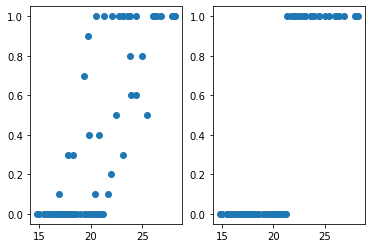

In [15]:
# 선형적인 관계 이외에 관계를 확인하고자 시각화를 해보자.

fig,axes = plt.subplots(1,2)
axes[0].scatter(train_x.Temp,train_x.Sun)
axes[1].scatter(train_x.Temp,Sun1)

/Users/namhunkim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


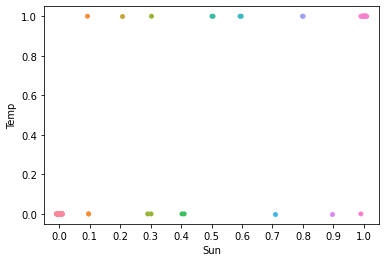

In [16]:
sns.stripplot(train_x.Sun,Sun1, jitter=True);

In [17]:
print('0,1이 아닌 Sun의 비율 : %1.2f%%'%(train_x.Sun.value_counts().iloc[2:].sum() / train_x.Sun.count() * 100))

0,1이 아닌 Sun의 비율 : 19.32%


In [18]:
# 일단 Sun1의 경우에는 꽤 그럴듯하게 Sun을 나타내는 것 같지만, 0,1이 아닌 값들이 꽤 있다.
# 로지스틱회귀 등으로 하면 더 잘 나타낼 수 있는 것 같지만, 이러한 과정은 뒤의 분류 혹은 회귀에서
# 사용될 것임으로 아래 4개의 지표를 사용하고자 한다.

답변 : ['Temp', 'Wind', 'Moisture', 'Sun']
이유
1. Precipitation은 자료의 분포가 극단적이라 큰 의미가 없었다.
2. 다른 4개의 피처는 서로 상관관계가 최대 0.78정도이나 어떠한 처리 없이 손쉽게 한 피처를 다른 피처로 나타낼 수 없었다.

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

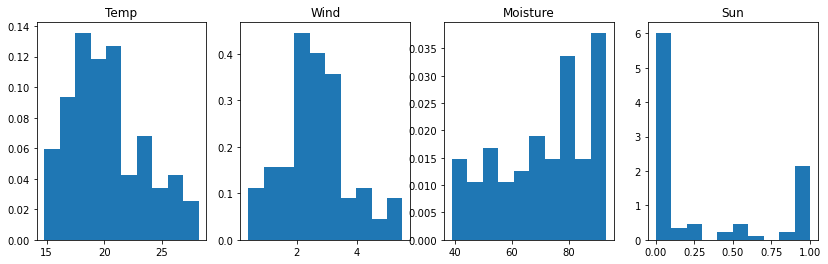

In [19]:
# 기존 데이터의 분포 확인

fig,axes = plt.subplots(1,4, figsize=(14,4))

for i in range(4):
    axes[i].hist(train_x.iloc[:,i], density=True)
    axes[i].set_title(train_x.columns[i])

In [20]:
# 사용할 패키지를 import!

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### 1. MinMaxScaler

In [21]:
scaler1 = MinMaxScaler()
scaler1 = scaler1.fit(train_x)
processed_data1 = scaler1.transform(train_x)
print(processed_data1[0:3,:],'\n')
print(processed_data1.shape)

[[0.20895522 0.41176471 0.98148148 0.        ]
 [0.21641791 0.49019608 0.96296296 0.        ]
 [0.20149254 0.54901961 0.96296296 0.        ]] 

(88, 4)


In [22]:
train_x_pro1 = pd.DataFrame(processed_data1, columns=train_x.columns)
train_x_pro1.head()

,Temp,Wind,Moisture,Sun
0,0.208955,0.411765,0.981481,0.0
1,0.216418,0.490196,0.962963,0.0
2,0.201493,0.549020,0.962963,0.0
3,0.171642,0.549020,0.962963,0.0
4,0.164179,0.568627,0.981481,0.0


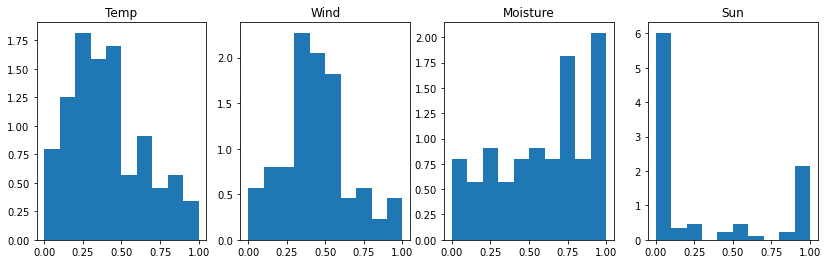

In [23]:
fig,axes = plt.subplots(1,4, figsize=(14,4))

for i in range(4):
    axes[i].hist(train_x_pro1.iloc[:,i], density=True)
    axes[i].set_title(train_x_pro1.columns[i])

# MinMaxScaler임으로 0,1의 스케일링을 제외하면 분포의 변화는 없는 것처럼 보인다.
# 따라서 변화전과 후를 비교해보자.

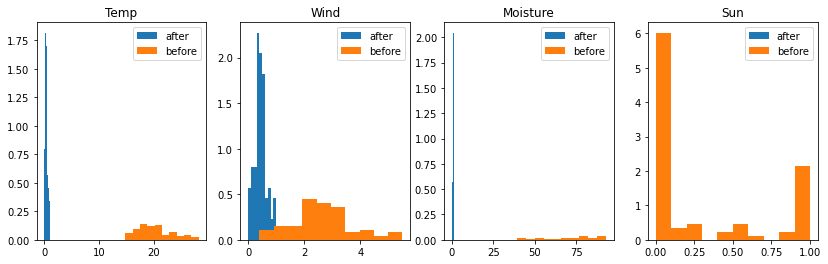

In [24]:
# 확실하게 변화 전과 후로 스케일링이 되었음을 확인할 수 있다.

fig,axes = plt.subplots(1,4, figsize=(14,4))

for i in range(4):
    axes[i].hist(train_x_pro1.iloc[:,i], density=True, label='after')
    axes[i].hist(train_x.iloc[:,i], density=True, label='before')
    axes[i].legend(ncol=1)
    axes[i].set_title(train_x.columns[i])

### 2. StandardScaler

In [25]:
scaler2 = StandardScaler()
scaler2 = scaler2.fit(train_x)
processed_data2 = scaler2.transform(train_x)
print(processed_data2[0:3,:],'\n')
print(processed_data2.shape)

[[-0.80942259 -0.12139024  1.32132616 -0.70431807]
 [-0.77879955  0.25016944  1.2583377  -0.70431807]
 [-0.84004563  0.5288392   1.2583377  -0.70431807]] 

(88, 4)


In [26]:
train_x_pro2 = pd.DataFrame(processed_data2, columns=train_x.columns)
train_x_pro2.head()

,Temp,Wind,Moisture,Sun
0,-0.809423,-0.121390,1.321326,-0.704318
1,-0.778800,0.250169,1.258338,-0.704318
2,-0.840046,0.528839,1.258338,-0.704318
3,-0.962538,0.528839,1.258338,-0.704318
4,-0.993161,0.621729,1.321326,-0.704318


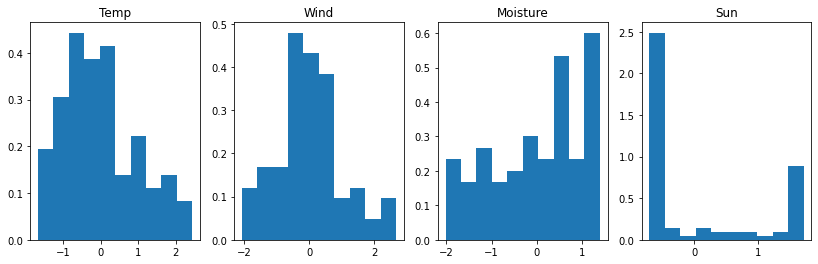

In [27]:
fig,axes = plt.subplots(1,4, figsize=(14,4))

for i in range(4):
    axes[i].hist(train_x_pro2.iloc[:,i], density=True)
    axes[i].set_title(train_x_pro2.columns[i])

# 변화전과 후를 비교해보자.

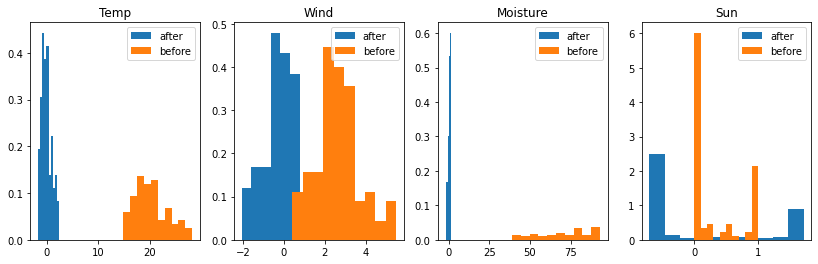

In [28]:
# 확실하게 변화 전과 후로 스케일링이 되었음을 확인할 수 있다.

fig,axes = plt.subplots(1,4, figsize=(14,4))

for i in range(4):
    axes[i].hist(train_x_pro2.iloc[:,i], density=True, label='after')
    axes[i].hist(train_x.iloc[:,i], density=True, label='before')
    axes[i].legend(ncol=1)
    axes[i].set_title(train_x.columns[i])

In [29]:
# processed_data1 <- MinMaxScaler
print('processed_data1 :',processed_data1.shape)
# processed_data2 <- StandardScaler
print('processed_data2 :',processed_data2.shape)

# 4개의 피처임으로 시각적인 확인이 쉽지는 않다.

processed_data1 : (88, 4)
processed_data2 : (88, 4)


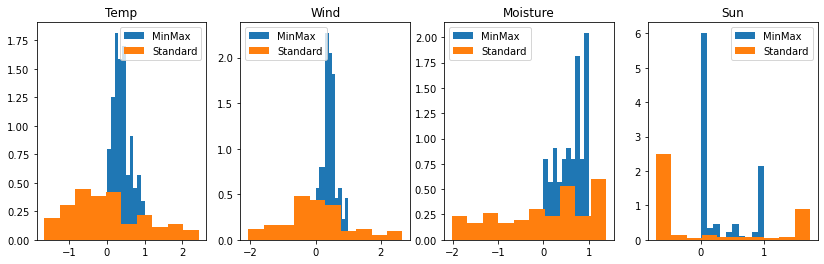

In [30]:
# MinMax와 Standard Scaler의 차이를 확인한다.

fig,axes = plt.subplots(1,4, figsize=(14,4))

for i in range(4):
    axes[i].hist(train_x_pro1.iloc[:,i], density=True, label='MinMax')
    axes[i].hist(train_x_pro2.iloc[:,i], density=True, label='Standard')
    axes[i].legend(ncol=1)
    axes[i].set_title(train_x.columns[i])

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

### 1. Linear Regression(다중선형회귀)


In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
# MSE 함수

def mse(pred, true):
    return np.mean((pred-true)**2)

In [33]:
# 선형회귀 모델 생성 후 fitting 시킵니다.

# 1. MinMaxScaler
# LinearRegression()을 [processed_data1, train_y]를 기반으로 훈련(train)시킨다.
# 훈련된 linear_model1은 나중에 Test에 그대로 사용된다.
linear_model1 = LinearRegression().fit(processed_data1, train_y)

# 훈련시킨 모델(linear_model1을 토대로 훈련데이터(processed_data1)를 넣어
# 결과값(linear_pred_y1)을 확인한다.
linear_pred_y1 = linear_model1.predict(processed_data1)
print(f"Linear1 {mse(linear_pred_y1, train_y):.10f}")


# 2. StandardScaler
linear_model2 = LinearRegression().fit(processed_data2, train_y)
linear_pred_y2 = linear_model2.predict(processed_data2)
print(f"Linear2 {mse(linear_pred_y2, train_y):.10f}",'\n')

Linear1 2839.0296065049
Linear2 2839.0296065049 



In [34]:
# MSE값이 갖게 나온다. 그러나 두 모델 자체는 다른 것 같다.
linear_model1==linear_model2

False

In [35]:
# 각 회귀계수 값도 다르다.
linear_model1.coef_

array([1056.32824875,   78.13550222,  452.51571686,  -60.40148469])

In [36]:
# 각 회귀계수 값도 다르다.
linear_model2.coef_

array([257.42209029,  16.49337916, 133.03897733, -24.94801953])

In [37]:
# 예측값은 다른 값이 있다고 하나
linear_pred_y2==linear_pred_y1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True])

In [38]:
linear_pred_y2[9]==linear_pred_y1[9]

False

In [39]:
# 실제로 보면 그냥 거의 같은 값이다. (아마도 컴퓨터 계산의 오차일듯)
print(linear_pred_y1[9], linear_pred_y2[9])

8051.5640906330245 8051.564090633024


In [40]:
# 다만, 두 모델간의 차이는 거의 없을 뿐이다. 사실 Scaler가 minmax 그리고 standard 모두
# 선형변환이기에 다중선형회귀에서는 차이가 거의 없을 수 있다.

In [41]:
np.dot(processed_data1, linear_model1.coef_) + linear_model1.intercept_

array([8125.18010481, 8130.81150545, 8119.64161819, 8088.10943166,
       8090.13837439, 8092.16731711, 8051.26146179, 8010.61496848,
       8034.52325385, 8051.56409063, 8055.77797003, 8101.17164667,
       8160.99062563, 8119.18393623, 8133.45940735, 8163.73369598,
       8164.35033832, 8139.49476802, 8072.33106299, 7980.26032017,
       7930.86978887, 7893.95350589, 7889.77128088, 7884.86947855,
       7881.72244816, 7863.07347431, 7852.40046111, 7825.90988715,
       7826.18405792, 7777.13100618, 7806.68571748, 7817.08455991,
       7851.99650108, 7894.02044405, 7875.27310649, 7934.47087184,
       7928.26972508, 7911.58275579, 8005.4809261 , 8012.00792764,
       8056.86851688, 8111.1692677 , 8075.22213191, 8084.37309742,
       8089.42473096, 8101.54691979, 8103.75711927, 8114.34723943,
       8108.94856305, 8122.42156379, 8136.61414186, 8128.95379851,
       8107.37504785, 8112.69083119, 8067.86690068, 8117.99682241,
       8144.9031977 , 8193.15310485, 8283.88261136, 8334.91292

In [42]:
linear_pred_y1

array([8125.18010481, 8130.81150545, 8119.64161819, 8088.10943166,
       8090.13837439, 8092.16731711, 8051.26146179, 8010.61496848,
       8034.52325385, 8051.56409063, 8055.77797003, 8101.17164667,
       8160.99062563, 8119.18393623, 8133.45940735, 8163.73369598,
       8164.35033832, 8139.49476802, 8072.33106299, 7980.26032017,
       7930.86978887, 7893.95350589, 7889.77128088, 7884.86947855,
       7881.72244816, 7863.07347431, 7852.40046111, 7825.90988715,
       7826.18405792, 7777.13100618, 7806.68571748, 7817.08455991,
       7851.99650108, 7894.02044405, 7875.27310649, 7934.47087184,
       7928.26972508, 7911.58275579, 8005.4809261 , 8012.00792764,
       8056.86851688, 8111.1692677 , 8075.22213191, 8084.37309742,
       8089.42473096, 8101.54691979, 8103.75711927, 8114.34723943,
       8108.94856305, 8122.42156379, 8136.61414186, 8128.95379851,
       8107.37504785, 8112.69083119, 8067.86690068, 8117.99682241,
       8144.9031977 , 8193.15310485, 8283.88261136, 8334.91292

Text(0.5, 1.0, 'Multiple Linear Regression; StandardScaler')

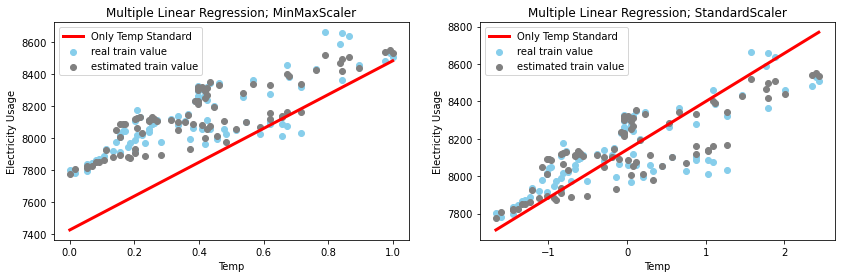

In [43]:
# 시각화 <- Temp기준; minmax
x1 = processed_data1[:,0] # Temp값
x_axis1 = np.linspace(np.min(x1), np.max(x1), 100) # Temp값의 범위안에서 100등분을 한 값들
# 적합시킨 회귀식을 이용해 100등분 한 Temp로 y값을 유추한다.  단, 다중선형회귀이지만
# Temp기준임으로 다른 피처들을 제외하고 Temp로만 한 직선값이 적용된다.
linear_fit1 = linear_model1.coef_[0] * x_axis1 + linear_model1.intercept_ 

# 시각화 <- Temp기준; standard
x2 = processed_data2[:,0] # Temp값
x_axis2 = np.linspace(np.min(x2), np.max(x2), 100) # Temp값의 범위안에서 100등분을 한 값들
# 적합시킨 회귀식을 이용해 100등분 한 Temp로 y값을 유추한다.  단, 다중선형회귀이지만
# Temp기준임으로 다른 피처들을 제외하고 Temp로만 한 직선값이 적용된다.
linear_fit2 = linear_model2.coef_[0] * x_axis2 + linear_model2.intercept_ 


fig,axes = plt.subplots(1,2, figsize=(14,4))

axes[0].plot(x_axis1, linear_fit1, label='Only Temp Standard', c='r', linewidth=3)
axes[0].scatter(x1, train_y, c='skyblue', label='real train value')
axes[0].scatter(x1, linear_pred_y1, c='gray', label='estimated train value')
axes[0].legend()
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('Electricity Usage')
axes[0].set_title('Multiple Linear Regression; MinMaxScaler')

axes[1].plot(x_axis2, linear_fit2, label='Only Temp Standard', c='r', linewidth=3)
axes[1].scatter(x2, train_y, c='skyblue', label='real train value')
axes[1].scatter(x2, linear_pred_y2, c='gray', label='estimated train value')
axes[1].legend()
axes[1].set_xlabel('Temp')
axes[1].set_ylabel('Electricity Usage')
axes[1].set_title('Multiple Linear Regression; StandardScaler')

### 2. Polynomial(다항회귀)

In [44]:
from sklearn.preprocessing import PolynomialFeatures

In [45]:
polynomial = PolynomialFeatures(2, include_bias=False) # 5가 되면 MSE가 0이된다.
# include_bias : 편향을 위한 bias변수(X0) 추가 여부

# 1. MinMaxScaler
x_poly1 = polynomial.fit_transform(processed_data1) # x^0, x^1, x^2를 만든다.
print(x_poly1.shape)
poly_model1 = LinearRegression().fit(x_poly1, train_y) # 모델학습
poly_pred_y1 = poly_model1.predict(x_poly1) # 예측
print(f"Poly1 {mse(poly_pred_y1, train_y):.10f}")


# 2. StandardScaler
x_poly2 = polynomial.fit_transform(processed_data2) # x^0, x^1, x^2를 만든다.
print(x_poly2.shape)
poly_model2 = LinearRegression().fit(x_poly2, train_y) # 모델학습
poly_pred_y2 = poly_model2.predict(x_poly2) # 예측
print(f"Poly2 {mse(poly_pred_y2, train_y):.10f}")

(88, 14)
Poly1 1141.7558435087
(88, 14)
Poly2 1141.7558435087


In [46]:
poly_model1.coef_

array([ 102.7169654 , -104.87895567,  -96.0916736 , -292.70272017,
        276.32535227,  202.08537922,  954.61929616,  207.88697164,
        -72.05017723,  246.56311429,  205.97695177,   37.63979962,
        117.92836375,   30.10394027])

In [47]:
poly_model2.coef_

array([253.97326287,  25.39747174, 140.67069939, -12.6873901 ,
        16.41022627,  10.39544409,  68.39468555,  20.92486442,
        -3.210388  ,  15.30151992,  17.95842823,   3.25340225,
        14.32029499,   5.13570733])

In [48]:
poly_model1==poly_model2

False

In [49]:
poly_pred_y1==poly_pred_y2

array([False,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False,  True, False,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True, False, False, False,  True,  True,  True, False, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False])

In [50]:
print(poly_pred_y1[0], poly_pred_y2[0])

8080.075939643579 8080.075939643578


In [51]:
# 그런데 Poly의 경우에는 다항회귀이기에 제곱이 들어가니까 비슷하지 않을 것 같은데.. 비슷하다.
# 왜 그런지는 모르겠다..
# 재미있는 건 이차항보다 더 높이면, MSE값이 달라진다는 것이다.
# 아마 우연인가? 수식적으로 증명이 가능할 것도 같으나, 알고리즘 내부를 알지 못하니 이쯤에서..

In [52]:
poly_model1.coef_.shape

(14,)

In [53]:
poly_model1.coef_ # 아마도 4개의 변수를 사용했음으로
# 차례대로 x1, x2, x3, x4, x1^2, x2^2, ..., x3*x4이지 않을까 싶다.

array([ 102.7169654 , -104.87895567,  -96.0916736 , -292.70272017,
        276.32535227,  202.08537922,  954.61929616,  207.88697164,
        -72.05017723,  246.56311429,  205.97695177,   37.63979962,
        117.92836375,   30.10394027])

In [54]:
x_poly1.shape

(88, 14)

In [55]:
x_poly1[:,0] == processed_data1[:,0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

Text(0.5, 1.0, 'Polynomial Regression; StandardScaler')

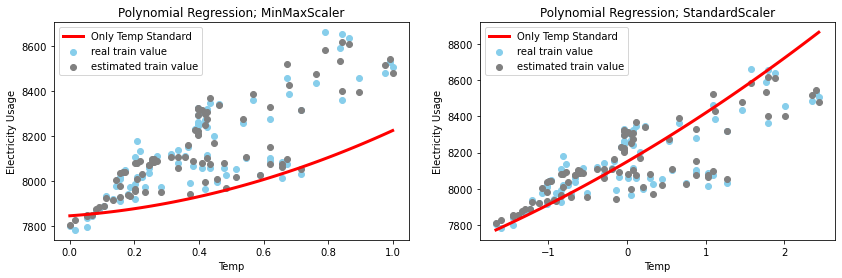

In [56]:
# 시각화 <- Temp기준; minmax
x1 = x_poly1[:,0] # Temp 1차식값
x_axis1 = np.linspace(np.min(x1), np.max(x1), 100) # Temp값의 범위안에서 100등분을 한 값들
poly_fit1 = poly_model1.coef_[0] * x_axis1 + poly_model1.coef_[4] * (x_axis1**2) + poly_model1.intercept_ 

# 시각화 <- Temp기준; standard
x2 = x_poly2[:,0] # Temp 1차식값
x_axis2 = np.linspace(np.min(x2), np.max(x2), 100) # Temp값의 범위안에서 100등분을 한 값들
poly_fit2 = poly_model2.coef_[0] * x_axis2 + poly_model2.coef_[4] * (x_axis2**2) + poly_model2.intercept_ 

fig,axes = plt.subplots(1,2, figsize=(14,4))

axes[0].plot(x_axis1, poly_fit1, label='Only Temp Standard', c='r', linewidth=3)
axes[0].scatter(x1, train_y, c='skyblue', label='real train value')
axes[0].scatter(x1, poly_pred_y1, c='gray', label='estimated train value')
axes[0].legend()
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('Electricity Usage')
axes[0].set_title('Polynomial Regression; MinMaxScaler')

axes[1].plot(x_axis2, poly_fit2, label='Only Temp Standard', c='r', linewidth=3)
axes[1].scatter(x2, train_y, c='skyblue', label='real train value')
axes[1].scatter(x2, poly_pred_y2, c='gray', label='estimated train value')
axes[1].legend()
axes[1].set_xlabel('Temp')
axes[1].set_ylabel('Electricity Usage')
axes[1].set_title('Polynomial Regression; StandardScaler')

### 3. Ridge Regression(회귀계수가 너무 크지 않게 제한)

In [57]:
from sklearn.linear_model import Ridge

In [58]:
# 1. MinMaxScaler
ridge_model1 = Ridge(random_state=123).fit(x_poly1, train_y) # 모델학습
ridge_pred_y1 = ridge_model1.predict(x_poly1) # 예측
print(f"Ridge {mse(ridge_pred_y1, train_y):.3f}")


# 2. StandardScaler
ridge_model2 = Ridge(random_state=123).fit(x_poly2, train_y) # 모델학습
ridge_pred_y2 = ridge_model2.predict(x_poly2) # 예측
print(f"Ridge {mse(ridge_pred_y2, train_y):.3f}")

Ridge 2620.713
Ridge 1189.346


In [59]:
# 여기서 확연히 다른 값이 나온다.

Text(0.5, 1.0, 'Ridge Regression; StandardScaler')

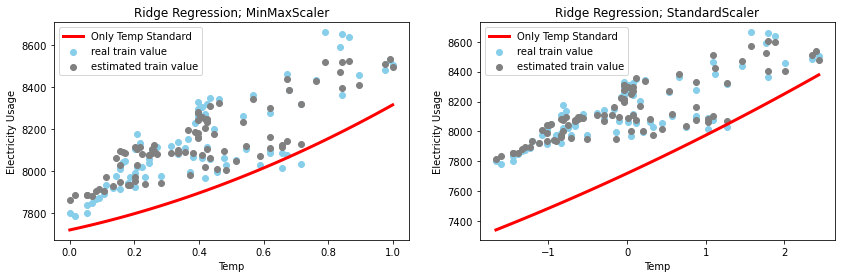

In [60]:
# 시각화 <- Temp기준; minmax
x1 = x_poly1[:,0] # Temp 1차식값
x_axis1 = np.linspace(np.min(x1), np.max(x1), 100) # Temp값의 범위안에서 100등분을 한 값들
ridge_fit1 = ridge_model1.coef_[0] * x_axis1 + ridge_model1.coef_[4] * (x_axis1**2) + ridge_model1.intercept_ 

# 시각화 <- Temp기준; standard
x2 = x_poly2[:,0] # Temp 1차식값
x_axis2 = np.linspace(np.min(x2), np.max(x2), 100) # Temp값의 범위안에서 100등분을 한 값들
ridge_fit2 = ridge_model2.coef_[0] * x_axis2 + ridge_model2.coef_[4] * (x_axis2**2) + ridge_model1.intercept_ 

fig,axes = plt.subplots(1,2, figsize=(14,4))

axes[0].plot(x_axis1, ridge_fit1, label='Only Temp Standard', c='r', linewidth=3)
axes[0].scatter(x1, train_y, c='skyblue', label='real train value')
axes[0].scatter(x1, ridge_pred_y1, c='gray', label='estimated train value')
axes[0].legend()
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('Electricity Usage')
axes[0].set_title('Ridge Regression; MinMaxScaler')

axes[1].plot(x_axis2, ridge_fit2, label='Only Temp Standard', c='r', linewidth=3)
axes[1].scatter(x2, train_y, c='skyblue', label='real train value')
axes[1].scatter(x2, ridge_pred_y2, c='gray', label='estimated train value')
axes[1].legend()
axes[1].set_xlabel('Temp')
axes[1].set_ylabel('Electricity Usage')
axes[1].set_title('Ridge Regression; StandardScaler')

In [61]:
# 여러 회귀모형의 MSE(훈련데이터의 y값과 훈련데이터x로 예측한 y값) 비교

print(f"Linear {mse(linear_pred_y1, train_y):.3f}")
print(f"Linear {mse(linear_pred_y2, train_y):.3f}",'\n')
print(f"Poly {mse(poly_pred_y1, train_y):.3f}")
print(f"Poly {mse(poly_pred_y2, train_y):.3f}",'\n')
print(f"Ridge {mse(ridge_pred_y1, train_y):.3f}")
print(f"Ridge {mse(ridge_pred_y2, train_y):.3f}")

Linear 2839.030
Linear 2839.030 

Poly 1141.756
Poly 1141.756 

Ridge 2620.713
Ridge 1189.346


In [62]:
# MSE가 낮은 순으로
# Poly < Ridge < Linear이다. <- 역시 이렇게 나오는게 통상적이다.

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [63]:
# 이전에 제거한 'Precipitation'항을 test_x에도 마찬가지로 제거해준다.

test_x = test_x.drop(['Precipitation'],axis=1)
test_x.head()

,Temp,Wind,Moisture,Sun
88,24.3,3.6,70.0,0.0
89,23.2,4.1,75.0,0.1
90,22.8,3.1,77.0,0.2
91,21.7,3.3,80.0,0.0
92,21.4,2.5,83.0,0.0


In [64]:
test_x1 = scaler1.transform(test_x) # 이전에 train_x를 MinMaxScaler로 fit한 결과를 토대로
# 똑같이 transform(적용 및 변형)시켜준다.
# 새로 fit을 하면 train_x와 test_x의 분포가 다름으로 올바르지 않게 된다.

test_x2 = scaler2.transform(test_x) # 이전에 train_x를 StandardScaler fit한 결과를 토대로

# 참고로 이전에 train_y는 스케일링을 하지 않았기에, test_y의 스케일링 또한 필요없다.

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [65]:
# Linear

Text(0.5, 1.0, 'Multiple Linear Regression; StandardScaler')

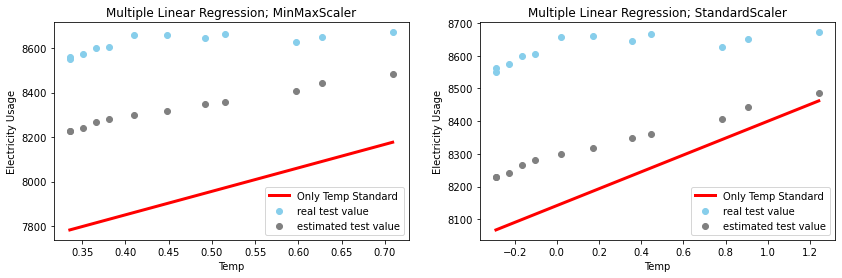

In [66]:
linear_pred_y3 = linear_model1.predict(test_x1) # train_x를 MinMaxScaler로 스케일링 후에
# 다중선형회귀로 적합시킨 모델(linear_model1)을, test_x에 MinMaxScaler로 스케일링 한 뒤에
# 적용시켜 예측한다. 이 값이 'linear_pred_y1'이다.
linear_pred_y4 = linear_model2.predict(test_x2)

# 시각화 <- Temp기준; minmax
x1 = test_x1[:,0] # Temp값
x_axis1 = np.linspace(np.min(x1), np.max(x1), 100) # Temp값의 범위안에서 100등분을 한 값들
linear_fit1 = linear_model1.coef_[0] * x_axis1 + linear_model1.intercept_ 

# 시각화 <- Temp기준; standard
x2 = test_x2[:,0] # Temp값
x_axis2 = np.linspace(np.min(x2), np.max(x2), 100) # Temp값의 범위안에서 100등분을 한 값들
linear_fit2 = linear_model2.coef_[0] * x_axis2 + linear_model2.intercept_ 


fig,axes = plt.subplots(1,2, figsize=(14,4))

axes[0].plot(x_axis1, linear_fit1, label='Only Temp Standard', c='r', linewidth=3)
axes[0].scatter(x1, test_y, c='skyblue', label='real test value')
axes[0].scatter(x1, linear_pred_y3, c='gray', label='estimated test value')
axes[0].legend()
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('Electricity Usage')
axes[0].set_title('Multiple Linear Regression; MinMaxScaler')

axes[1].plot(x_axis2, linear_fit2, label='Only Temp Standard', c='r', linewidth=3)
axes[1].scatter(x2, test_y, c='skyblue', label='real test value')
axes[1].scatter(x2, linear_pred_y4, c='gray', label='estimated test value')
axes[1].legend()
axes[1].set_xlabel('Temp')
axes[1].set_ylabel('Electricity Usage')
axes[1].set_title('Multiple Linear Regression; StandardScaler')

In [67]:
# Polynomial

Text(0.5, 1.0, 'Polynomial Regression; StandardScaler')

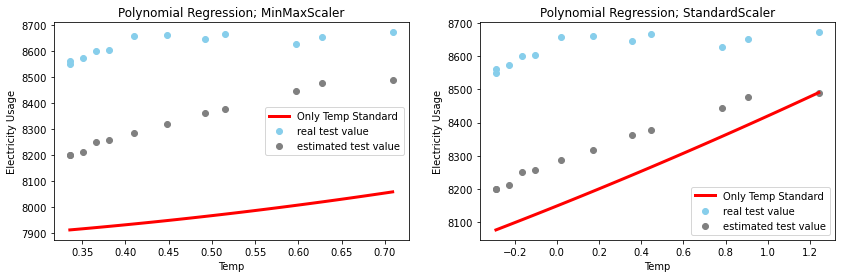

In [68]:
test_x_poly1 = polynomial.fit_transform(test_x1) # MinMaxScaler에 대한 x^1, x^2,... 차수 늘리기
test_x_poly2 = polynomial.fit_transform(test_x2) # StandardScaler 대한 x^1, x^2,... 차수 늘리기
poly_pred_y3 = poly_model1.predict(test_x_poly1) # test-set 예측
poly_pred_y4 = poly_model2.predict(test_x_poly2) # test-set 예측


# 시각화 <- Temp기준; minmax
x1 = test_x_poly1[:,0] # Temp 1차식값(ex. x1^1)
x_axis1 = np.linspace(np.min(x1), np.max(x1), 100) # Temp값의 범위안에서 100등분을 한 값들
poly_fit1 = poly_model1.coef_[0] * x_axis1 + poly_model1.coef_[4] * (x_axis1**2) + poly_model1.intercept_ 

# 시각화 <- Temp기준; standard
x2 = test_x_poly2[:,0] # Temp 1차식값(ex. x1^1)
x_axis2 = np.linspace(np.min(x2), np.max(x2), 100) # Temp값의 범위안에서 100등분을 한 값들
poly_fit2 = poly_model2.coef_[0] * x_axis2 + poly_model2.coef_[4] * (x_axis2**2) + poly_model2.intercept_ 

fig,axes = plt.subplots(1,2, figsize=(14,4))

axes[0].plot(x_axis1, poly_fit1, label='Only Temp Standard', c='r', linewidth=3)
axes[0].scatter(x1, test_y, c='skyblue', label='real test value')
axes[0].scatter(x1, poly_pred_y3, c='gray', label='estimated test value')
axes[0].legend()
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('Electricity Usage')
axes[0].set_title('Polynomial Regression; MinMaxScaler')

axes[1].plot(x_axis2, poly_fit2, label='Only Temp Standard', c='r', linewidth=3)
axes[1].scatter(x2, test_y, c='skyblue', label='real test value')
axes[1].scatter(x2, poly_pred_y4, c='gray', label='estimated test value')
axes[1].legend()
axes[1].set_xlabel('Temp')
axes[1].set_ylabel('Electricity Usage')
axes[1].set_title('Polynomial Regression; StandardScaler')

In [69]:
# Ridge

Text(0.5, 1.0, 'Ridge Regression; StandardScaler')

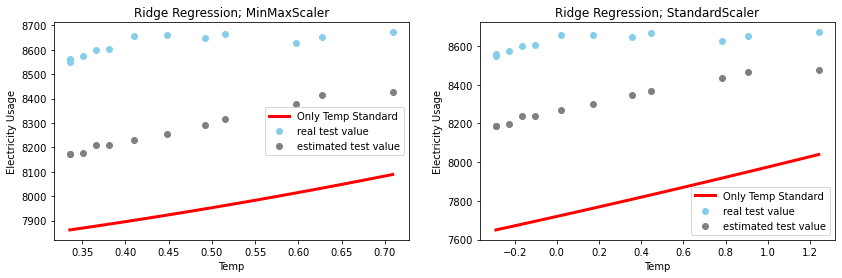

In [70]:
ridge_pred_y3 = ridge_model1.predict(test_x_poly1) # test-set 예측
ridge_pred_y4 = ridge_model2.predict(test_x_poly2) # test-set 예측

# 시각화 <- Temp기준; minmax
x1 = test_x_poly1[:,0] # Temp 1차식값(ex. x1^1)
x_axis1 = np.linspace(np.min(x1), np.max(x1), 100) # Temp값의 범위안에서 100등분을 한 값들
ridge_fit1 = ridge_model1.coef_[0] * x_axis1 + ridge_model1.coef_[4] * (x_axis1**2) + ridge_model1.intercept_ 

# 시각화 <- Temp기준; standard
x2 = test_x_poly2[:,0] # Temp 1차식값(ex. x1^1)
x_axis2 = np.linspace(np.min(x2), np.max(x2), 100) # Temp값의 범위안에서 100등분을 한 값들
ridge_fit2 = ridge_model2.coef_[0] * x_axis2 + ridge_model2.coef_[4] * (x_axis2**2) + ridge_model1.intercept_ 

fig,axes = plt.subplots(1,2, figsize=(14,4))

axes[0].plot(x_axis1, ridge_fit1, label='Only Temp Standard', c='r', linewidth=3)
axes[0].scatter(x1, test_y, c='skyblue', label='real test value')
axes[0].scatter(x1, ridge_pred_y3, c='gray', label='estimated test value')
axes[0].legend()
axes[0].set_xlabel('Temp')
axes[0].set_ylabel('Electricity Usage')
axes[0].set_title('Ridge Regression; MinMaxScaler')

axes[1].plot(x_axis2, ridge_fit2, label='Only Temp Standard', c='r', linewidth=3)
axes[1].scatter(x2, test_y, c='skyblue', label='real test value')
axes[1].scatter(x2, ridge_pred_y4, c='gray', label='estimated test value')
axes[1].legend()
axes[1].set_xlabel('Temp')
axes[1].set_ylabel('Electricity Usage')
axes[1].set_title('Ridge Regression; StandardScaler')

In [71]:
# 여러 회귀모형의 MSE(테스트데이터의 y값과 테스트데이터x로 예측한 y값) 비교

print(f"Linear {mse(linear_pred_y3, test_y):.3f}")
print(f"Linear {mse(linear_pred_y4, test_y):.3f}",'\n')
print(f"Poly {mse(poly_pred_y3, test_y):.3f}")
print(f"Poly {mse(poly_pred_y4, test_y):.3f}",'\n')
print(f"Ridge {mse(ridge_pred_y3, test_y):.3f}")
print(f"Ridge {mse(ridge_pred_y4, test_y):.3f}")

Linear 90975.195
Linear 90975.195 

Poly 94847.734
Poly 94847.734 

Ridge 127259.141
Ridge 102820.794


In [72]:
# 이전과 달리 가장 좋은 모델은 Linear, Poly, Ridge순이다.
# 어떻게 결과가 아예 반대로 나올 수 있는지 의문스럽지만...
# 일단 결과는 그렇다.

In [73]:
# score = MSE(Train) / MSE(Test)

def score(train_mse, test_mse): # 왜 MSE의 비를 사용하는지는 모르겠다.
    return (test_mse/train_mse)

In [74]:
# score 점수 비교
print(f"Linear {score(mse(linear_pred_y1, train_y),mse(linear_pred_y3, test_y)):.3f}")
print(f"Linear {score(mse(linear_pred_y2, train_y),mse(linear_pred_y4, test_y)):.3f}\n")

print(f"Poly {score(mse(poly_pred_y1, train_y),mse(poly_pred_y3, test_y)):.3f}")
print(f"Poly {score(mse(poly_pred_y2, train_y),mse(poly_pred_y4, test_y)):.3f}\n")

print(f"Ridge {score(mse(ridge_pred_y1, train_y),mse(ridge_pred_y3, test_y)):.3f}")
print(f"Ridge {score(mse(ridge_pred_y2, train_y),mse(ridge_pred_y4, test_y)):.3f}")

Linear 32.044
Linear 32.044

Poly 83.072
Poly 83.072

Ridge 48.559
Ridge 86.452


In [75]:
# score = MSE(Train) / MSE(Test) 임으로
# score이 클수록 좋은 값이다. 왜냐하면 MSE(Test)와 MSE(Train)은 모두 작을수록 좋지만
# MSE(Test)가 MSE(Train)보다 작아야 과적합이 되지 않았다는 뜻이기 때문이다.

# 따라서 StandardScaler를 사용한 Ridge모델(ridge_model2)이 가장 좋으며,
# 그 다음은 Poly모델(poly_model1,poly_model2), MinMaxScaler를 사용한 Ridge모델(ridge_model1)
# 마지막은 Linear모델(linear_model1,linear_model2)이다.